## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

- This notebooks servers as an example on how to extract surface (or any other 2D spatial field) properties from a selected spacial region accross all LENS2 members for the ocean component. 

## Imports

In [1]:
import intake
import intake_esm
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import fsspec
import cmocean
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pop_tools
import sys
from distributed import Client
from ncar_jobqueue import NCARCluster
sys.path.append('../functions')
import util
from cartopy.util import add_cyclic_point
from misc import get_ij
import warnings, getpass, os

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/apps/opt/conda/envs/npl-2022b/share/proj failed


<div class="alert alert-block alert-info">
<b>Note:</b> comment the following line when debugging
</div>

In [2]:
warnings.filterwarnings("ignore")

### Local functions

In [3]:
def rms_da(da, dims=('nlat', 'nlon'), weights=None,  weights_sum=None):
  """
  Calculates the rms in DataArray da (optional weighted rms).

  ----------
  da : xarray.DataArray
        DataArray for which to compute (weighted) rms.

  dims : tuple, str
    Dimension(s) over which to apply reduction. Default is ('yh', 'xh').

  weights : xarray.DataArray, optional
    weights to apply. It can be a masked array.

  weights_sum : xarray.DataArray, optional
    Total weight (i.e., weights.sum()). Only computed if not provided.

  Returns
  -------
  reduction : DataSet
      xarray.Dataset with (optionally weighted) rms for da.
  """

  if weights is not None:
    if weights_sum is None: weights_sum = weights.sum(dim=dims)
    out = np.sqrt((da**2 * weights).sum(dim=dims)/weights_sum)
    # copy attrs
    out.attrs = da.attrs
    return out
  else:
    return np.sqrt((da**2).mean(dim=dims, keep_attrs=True))

### Dask workers

In [4]:
mem_per_worker = 150 # in GB 
num_workers = 80 
cluster = NCARCluster(cores=4, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.51:33187' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:33187,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Data Ingest

In [5]:
%%time
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

CPU times: user 28.4 s, sys: 2.16 s, total: 30.6 s
Wall time: 31.3 s


In [6]:
catalog.search(component='ocn').unique('frequency')

{'frequency': {'count': 3, 'values': ['month_1', 'year_1', 'day_1']}}

### Let's search for variables with montly frequency

In [7]:
cat_subset = catalog.search(component='ocn',
                            frequency='month_1',
                            variable=['TEMP','SHF']) # TEMP, Total Surface Heat Flux

In [8]:
%%time
dset_dict_raw = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 11s, sys: 2.38 s, total: 1min 13s
Wall time: 1min 28s


In [9]:
# print keys
[key for key in dset_dict_raw.keys()]

['ocn.historical.pop.h.smbb.TEMP',
 'ocn.ssp370.pop.h.cmip6.TEMP',
 'ocn.historical.pop.h.cmip6.TEMP',
 'ocn.ssp370.pop.h.smbb.TEMP',
 'ocn.historical.pop.h.smbb.SHF',
 'ocn.ssp370.pop.h.cmip6.SHF',
 'ocn.historical.pop.h.cmip6.SHF',
 'ocn.ssp370.pop.h.smbb.SHF']

In [10]:
# Temperature
fb=('TEMP','SHF')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_hist_cmip6_{fb[ifb]} = dset_dict_raw[\'ocn.historical.pop.h.cmip6.{fb[ifb]}\']'
    exec(str)
    str=f'ds_hist_smbb_{fb[ifb]} = dset_dict_raw[\'ocn.historical.pop.h.smbb.{fb[ifb]}\']'
    exec(str)
    str=f'ds_hist_{fb[ifb]} = xr.concat([ds_hist_cmip6_{fb[ifb]},ds_hist_smbb_{fb[ifb]}], dim=\'member_id\',data_vars=\'minimal\',coords=\'minimal\',compat=\'override\')'
    exec(str)
    str=f'mem=ds_hist_{fb[ifb]}.{fb[ifb]}.nbytes*1e-12 # in TB'
    exec(str)
    print(f'Memory: {mem} TB')
print(f'Done!')

Variable: TEMP
Memory: 5.8392576 TB
Variable: SHF
Memory: 0.09732096 TB
Done!


### Import the POP grid

If you choose the ocean component of LENS2, you will need to import the POP grid. For the other components, you can use the emsemble's own grid. 

In ds, TLONG and TLAT have missing values (NaNs), so we need to override them with the values from pop_grid, which does not have missing values.

In [11]:
# Read the pop 1 deg grid from pop_tools
# We will use variables TLONG and TLAT
pop_grid = pop_tools.get_grid('POP_gx1v7')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_hist_{fb[ifb]}[\'TLONG\'] = pop_grid.TLONG'     # Longitud
    exec(str)
    str=f'ds_hist_{fb[ifb]}[\'TLAT\'] = pop_grid.TLAT'       # Latitudes
    exec(str)
    str=f'ds_hist_{fb[ifb]}[\'TLONG\'] = pop_grid.TLONG'     # Longitud
    exec(str)
    str=f'ds_hist_{fb[ifb]}[\'TLAT\'] = pop_grid.TLAT'       # Latitudes
    exec(str)

Variable: TEMP
Variable: SHF


Text(0.5, 1.0, 'i1231p1f1')

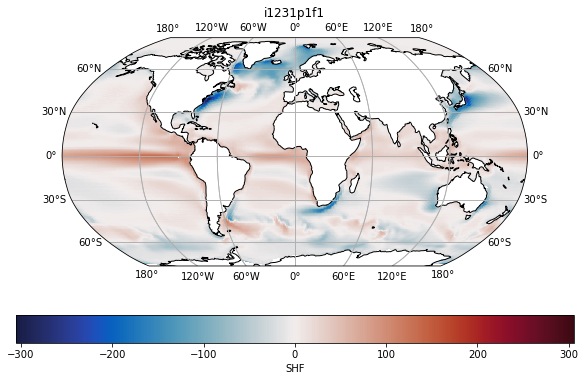

In [12]:
ds_var_1231 = ds_hist_SHF.SHF.sel(member_id=['r1i1231p1f1','r2i1231p1f1','r3i1231p1f1','r4i1231p1f1','r5i1231p1f1','r6i1231p1f1','r7i1231p1f1','r8i1231p1f1','r9i1231p1f1','r10i1231p1f1']).mean(dim='time')#.plot()
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = ds_var_1231.mean(dim='member_id').plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='TLONG',
                    y='TLAT',
                    #vmin=-3,
                    #vmax=30,
                    cbar_kwargs={'orientation': 'horizontal'})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();
plt.title('i1231p1f1')

### Centralize the South Atlantic 
Need to combine the domain in the east/west direction to centralize the South Atlantic

In [13]:
ilat, flat = 101, 182
ilon1, flon1, ilon2, flon2 = 313, 320, 0, 57
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'sa_ds_{fb[ifb]}=xr.combine_nested([[ds_hist_{fb[ifb]}.isel(nlat = slice(ilat,flat),nlon = slice(ilon1,flon1)),ds_hist_{fb[ifb]}.isel(nlat = slice(ilat,flat),nlon = slice(ilon2,flon2))]],concat_dim=[\'nlat\',\'nlon\'])'
    exec(str)
    str=f'sa_ds_{fb[ifb]}.coords[\'TLONG\'] = (sa_ds_{fb[ifb]}.coords[\'TLONG\'] + 180) % 360 - 180' # change the longitudes: -180 0 180
    exec(str)

Variable: TEMP
Variable: SHF


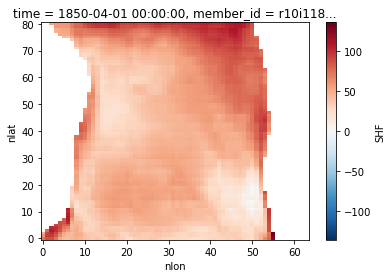

In [14]:
# simple check
sa_ds_SHF.SHF.isel(time=2, member_id=0).plot()

CPU times: user 187 ms, sys: 9.23 ms, total: 196 ms
Wall time: 528 ms


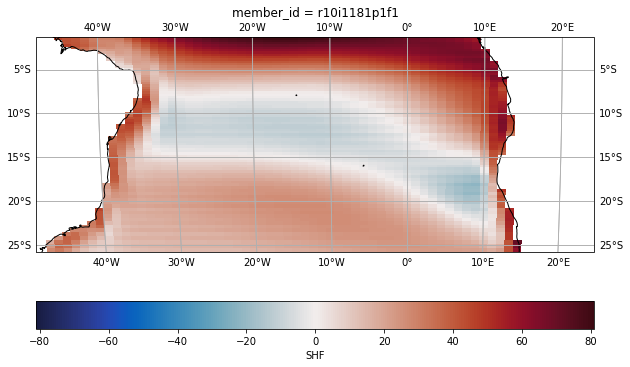

In [15]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = sa_ds_SHF.SHF.isel(member_id=0).mean(dim='time').plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='TLONG',
                    y='TLAT',
                    #vmin=10,
                    #vmax=30,
                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();

### Extract correponding area 

In [16]:
area_sa = xr.combine_nested([
    [pop_grid.TAREA.isel(nlat = slice(ilat,flat),nlon = slice(ilon1,flon1)),
     pop_grid.TAREA.isel(nlat = slice(ilat,flat),nlon = slice(ilon2,flon2))]],
    concat_dim=['nlat','nlon']
)

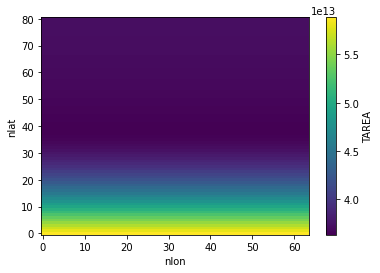

In [17]:
# simple check
area_sa.plot();

### Perfom computations
Calculate area mean, min, max, and rms for the surface temperature of the selected region

In [18]:
%%time
start="1850-01-01"
end="2014-12-31"
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'var_{fb[ifb]} = sa_ds_{fb[ifb]}.{fb[ifb]}.sel(time=slice(start,end))'
    exec(str)
    # Mean
    str=f'var_mean_{fb[ifb]} = var_{fb[ifb]}.weighted(area_sa).mean(dim=(\'nlon\',\'nlat\')).load()'
    exec(str)
    # Maximum
    str=f'var_max_{fb[ifb]} = var_{fb[ifb]}.max(dim=(\'nlon\',\'nlat\')).load()'
    exec(str)
    # Minimum
    str=f'var_min_{fb[ifb]} = var_{fb[ifb]}.min(dim=(\'nlon\',\'nlat\')).load()'
    exec(str)
    # RMS
    str=f'var_rms_{fb[ifb]} = rms_da(var_{fb[ifb]}, weights=area_sa, weights_sum=area_sa.sum()).load()'
    exec(str)

Variable: TEMP
Variable: SHF
CPU times: user 6min 12s, sys: 10.7 s, total: 6min 23s
Wall time: 29min 34s


### TODO
Plot some time series to check calculations

### Merge data and save on disk

In [19]:
units=('oC','W/m2')
long_name=('Temperature','Total Surface Heat Flux')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_out_{fb[ifb]} = xr.merge([var_rms_{fb[ifb]}.rename(\'{fb[ifb]}_rms\'),var_mean_{fb[ifb]}.rename(\'{fb[ifb]}_mean\'),var_max_{fb[ifb]}.rename(\'{fb[ifb]}_max\'),var_min_{fb[ifb]}.rename(\'{fb[ifb]}_min\')])'
    exec(str)
    str=f'ds_out_{fb[ifb]}.attrs[\'description\'] = \'{long_name[ifb]} ({fb[ifb]} [{units[ifb]}]) statistics for the South Atlantic (~47.5W-~23.75E and ~25.91623S-~1.413613S) made by Mauricio Rocha (mauricio.rocha@usp.br).\''
    exec(str)

Variable: TEMP
Variable: SHF


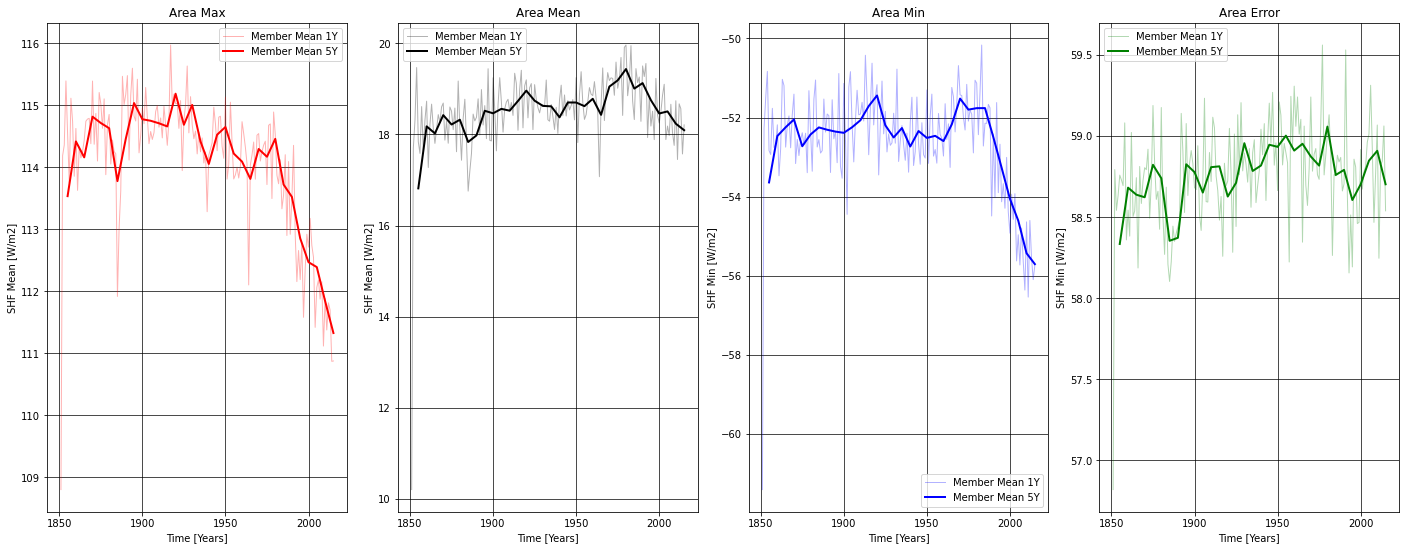

In [21]:
# To
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
#ds_out.shf_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.1,linewidth=1,add_legend=False)
ds_out_SHF.SHF_max.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_max.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('SHF Mean [W/m2]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(103,108.2)
fig.tight_layout(pad=2.0)
# Mean
#ds_out.shf_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.1,linewidth=1,add_legend=False)
ds_out_SHF.SHF_mean.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_mean.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('SHF Mean [W/m2]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(17,25.5)
# Minimum
#ds_out.shf_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.1,linewidth=1,add_legend=False)
ds_out_SHF.SHF_min.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_min.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('SHF Min [W/m2]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(-63,-51)
# Minimum
#ds_out.shf_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.1,linewidth=1,add_legend=False)
ds_out_SHF.SHF_rms.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_rms.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('SHF Min [W/m2]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(50.3,52)

plt.show()

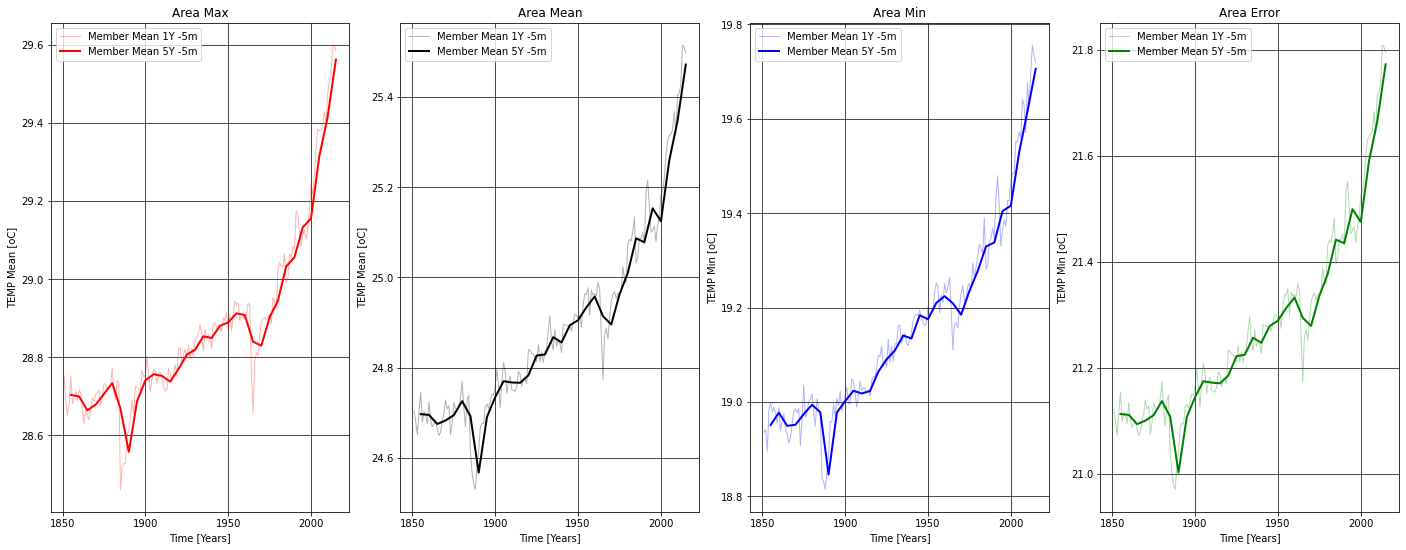

In [22]:
# Temperature
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
#ds_out.shf_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_max.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_max.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y -5m')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('TEMP Mean [oC]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(28.78,30.015)
fig.tight_layout(pad=2.0)
# Mean
#ds_out.shf_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_mean.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_mean.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y -5m')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('TEMP Mean [oC]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(25.7,26.7)
# Minimum
#ds_out.shf_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_min.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_min.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y -5m')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('TEMP Min [oC]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(20.7,21.7)
# Minimum
#ds_out.shf_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_rms.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_rms.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y -5m')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('TEMP Min [oC]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(19.4,20.2)

plt.show()

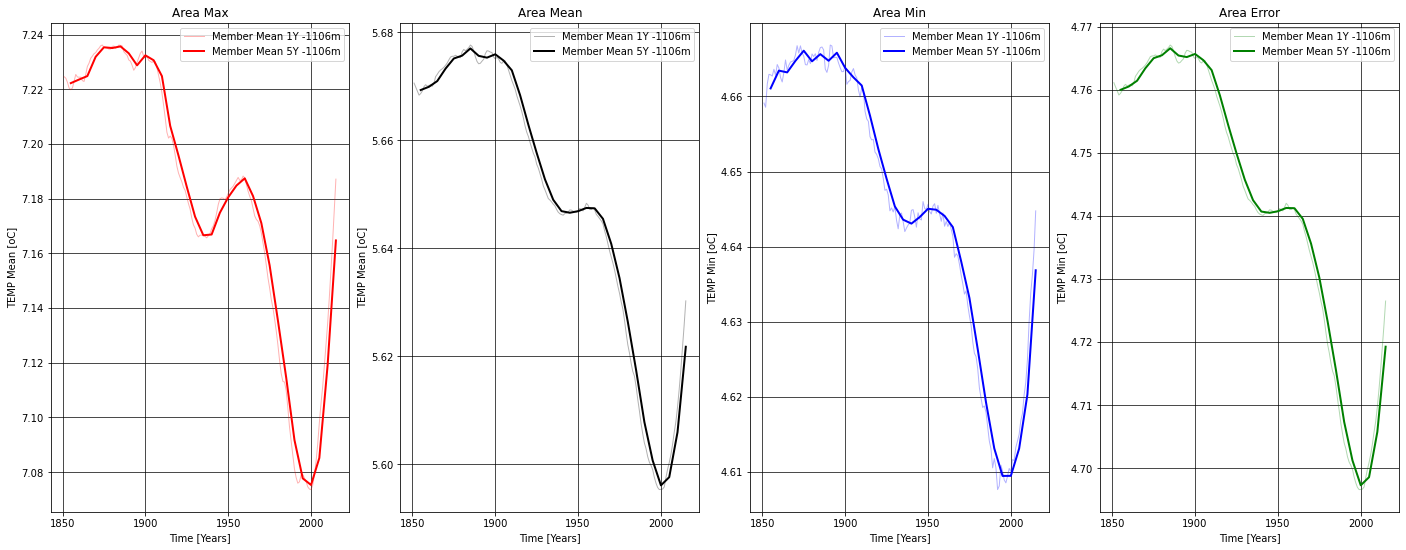

In [23]:
# Temperature
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
#ds_out.shf_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_max.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_max.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y -1106m')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('TEMP Mean [oC]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(28.78,30.015)
fig.tight_layout(pad=2.0)
# Mean
#ds_out.shf_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_mean.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_mean.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y -1106m')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('TEMP Mean [oC]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(25.7,26.7)
# Minimum
#ds_out.shf_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_min.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_min.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y -1106m')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('TEMP Min [oC]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(20.7,21.7)
# Minimum
#ds_out.shf_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_rms.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_rms.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y -1106m')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('TEMP Min [oC]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(19.4,20.2)

plt.show()

### Let's save the data in netcdf format

In [24]:
# create a directory on scratch to save the output
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'path = \'/glade/scratch/mauricio/LENS2_south_atlantic/{fb[ifb]}/\'.format(getpass.getuser())'
    exec(str)
    str=f'os.system(\'mkdir -p \'+path)'
    exec(str)
    str=f'ds_out_{fb[ifb]}.to_netcdf(path+\'{fb[ifb]}_stats.nc\')'
    exec(str)

Variable: TEMP
Variable: SHF
